# 深度持续学习工艺模拟器

In [1]:
# ========== 第二步：导入其他库 ==========
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from typing import Literal
from datetime import timedelta
from torchmetrics import MeanAbsolutePercentageError, MeanAbsoluteError
from tqdm import tqdm

# 忽视 Transformer 的警告
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.transformer")

# ========== 第三步：设置设备并验证 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 导入数据

### 真实数据

In [2]:
# 导入CSV文件
df_Original = pd.read_csv('Data_WaterTreatmentProcess_Clean.csv')

# 查看前几行数据
print("原始数据：")
print(df_Original.head())

原始数据：
          datetime  out_pH  out_turbidity  out_residual chlorine  out_CODmn  \
0  2022/10/11 0:00   7.707          0.053                  0.773     1.2040   
1  2022/10/11 1:00   7.709          0.052                  0.797     1.1941   
2  2022/10/11 2:00   7.712          0.052                  0.797     1.1772   
3  2022/10/11 3:00   7.720          0.052                  0.784     1.1737   
4  2022/10/11 4:00   7.725          0.052                  0.777     1.1737   

   in_temperature  in_turbidity  in_pH  in_CODmn  in_dissolved oxygen  \
0            17.8         11.09   7.74      3.49                 8.77   
1            17.7         11.15   7.82      3.45                 8.85   
2            17.9         10.87   7.74      3.51                 8.78   
3            17.4         10.93   7.81      3.47                 8.77   
4            17.7         10.87   7.75      3.47                 8.77   

   in_algal density  pre-ozone dose  coagulant dose  post-ozone dose  \
0       

#### 如果用虚拟数据，请注释掉

**修改数据为模板格式：**

In [3]:
# 创建df的副本
df = df_Original.copy()

# (1) 从datetime列生成Day和Hour列，并删除datetime列
# 将字符串格式的datetime转换为pandas datetime对象
df['datetime'] = pd.to_datetime(df['datetime'])
# 提取一年中的天数
df['Day'] = df['datetime'].dt.dayofyear
# 提取一天中的小时数
df['Hour'] = df['datetime'].dt.hour
# 删除原始的datetime列
df = df.drop('datetime', axis=1)

# (2) 将所有以'in_'开头的列名改为以'Influent_'开头
in_columns = [col for col in df.columns if col.startswith('in_')]
rename_dict = {col: 'Influent_' + col[3:] for col in in_columns}
df = df.rename(columns=rename_dict)

# (3) 将所有以'out_'开头的列名改为以'Effluent_'开头
out_columns = [col for col in df.columns if col.startswith('out_')]
rename_dict = {col: 'Effluent_' + col[4:] for col in out_columns}
df = df.rename(columns=rename_dict)

# (4) 将所有以'dose'结尾的列名改为以'Dosage_'开头，并去掉结尾的'dose'
dose_columns = [col for col in df.columns if col.endswith('dose')]
rename_dict = {}
for col in dose_columns:
    # 去掉'_dose'后缀
    prefix = col[:-5]
    new_col = 'Dosage_' + prefix
    rename_dict[col] = new_col
df = df.rename(columns=rename_dict)

# (5) 重新排列列：先是Day和Hour，然后是Influent开头的列，接着是Dosage开头的列，最后是Effluent开头的列
day_hour_cols = ['Day', 'Hour']
influent_cols = [col for col in df.columns if col.startswith('Influent_')]
dosage_cols = [col for col in df.columns if col.startswith('Dosage_')]
effluent_cols = [col for col in df.columns if col.startswith('Effluent_')]

# 按指定顺序重新排列列
new_column_order = day_hour_cols + influent_cols + dosage_cols + effluent_cols
df = df[new_column_order]

# 查看结果
print("修改为模板格式之后：")
print(df.head())
print("\nShape of data:", df.shape)
print("")


def get_effluent_variable_names(df):
    """
    从 DataFrame 中获取以 "Effluent_" 开头的列名，并进行格式化。
    特殊处理 "ph"，将其转换为 "PH"。

    Args:
        df: Pandas DataFrame。

    Returns:
        list: 格式化的变量名称列表。
    """
    variable_names = []
    for col in df.columns:
        if col.startswith("Effluent_"):
            name = col.replace("Effluent_", "")
            if name.lower() == "ph":  # 特殊处理 ph
                name = "PH"
            else:
                name = name.capitalize()
            variable_names.append(name)
    return variable_names

variable_names = get_effluent_variable_names(df)
print("出水水质指标依次是：", variable_names)

修改为模板格式之后：
   Day  Hour  Influent_temperature  Influent_turbidity  Influent_pH  \
0  284     0                  17.8               11.09         7.74   
1  284     1                  17.7               11.15         7.82   
2  284     2                  17.9               10.87         7.74   
3  284     3                  17.4               10.93         7.81   
4  284     4                  17.7               10.87         7.75   

   Influent_CODmn  Influent_dissolved oxygen  Influent_algal density  \
0            3.49                       8.77                 370.747   
1            3.45                       8.85                 470.250   
2            3.51                       8.78                 472.708   
3            3.47                       8.77                 429.420   
4            3.47                       8.77                 433.488   

   Dosage_pre-ozone  Dosage_coagulant  Dosage_post-ozone  \
0          0.225191         17.397385           1.015775   
1        

## 给出相关指标的位置！

In [4]:
# 设置药剂指标 (都是从0开始数)
dosage_indices = [8, 9, 10, 11]  # 在所有指标中的位置
# 设置受约束水质指标
output_water_indices = [0, 1, 3]  # 在出水水质中的位置
input_water_indices = [4, 3, 5]  # 在所有指标中的位置

## 将数据归一化

In [5]:
class DataPreprocessor:
    """
    数据预处理器。

    数据预处理有一定的复杂性，因为相同的水质（进水和出水）要使用相同的线性变换。
    """

    def __init__(self, scaler_type: Literal["minmax", "standard"] = "minmax", 
                 cyclic_time: bool = True):
        """Initializes the data preprocessor."""
        self.scaler_type = scaler_type
        self.cyclic_time = cyclic_time
        self.scalers = {}  # 使用字典存储不同的 scaler
        self.effluent_cols = None # 在 fit 中初始化
        self.other_cols = None # 在 fit 中初始化


    def fit(self, train_df: pd.DataFrame):
        """Fits the scalers based on the training data."""
        train_df_processed = train_df.copy()
        if self.cyclic_time:
            train_df_processed = self._time_to_cyclic(train_df_processed)

        self.effluent_cols = [col for col in train_df_processed.columns if col.startswith("Effluent")]
        self.other_cols = [col for col in train_df_processed.columns if not col.startswith("Effluent")]

        # 为对应水质指标创建相同的 scaler，并将 input 和 output 的列合并为一个数组进行 fit
        for i in range(len(input_water_indices)):
            input_idx = input_water_indices[i]
            output_idx = len(self.other_cols) + output_water_indices[i]

            if self.scaler_type == "minmax":
                scaler = MinMaxScaler()
            elif self.scaler_type == "standard":
                scaler = StandardScaler()
            else:
                raise ValueError("Invalid scaler_type. Choose 'minmax' or 'standard'.")

            #  将同一种水质的进水和出水列合并，使用同一个 scaler 进行 fit
            combined_data = np.concatenate(
                [
                    train_df_processed[[self.other_cols[input_idx]]].values, 
                    train_df_processed[[self.effluent_cols[output_water_indices[i]]]].values
                ], 
                axis=0
            )
            # print("Shape of the combined data", combined_data.shape)
            scaler.fit(combined_data)
            self.scalers[input_idx] = scaler  # 使用 input_idx 作为 key
            self.scalers[output_idx] = scaler  # 使用 output_idx 作为 key，确保使用相同的 scaler

        # 为其余列创建单独的 scaler
        remaining_indices = [i for i in range(len(self.other_cols)) if i not in input_water_indices] \
                + [i + len(self.other_cols) for i in range(len(self.effluent_cols)) if i not in output_water_indices]
        for i in remaining_indices:
            col_name = train_df_processed.columns[i]
            if self.scaler_type == "minmax":
                scaler = MinMaxScaler()
            elif self.scaler_type == "standard":
                scaler = StandardScaler()
            else:
                raise ValueError("Invalid scaler_type. Choose 'minmax' or 'standard'.")
            scaler.fit(train_df_processed[[col_name]])
            self.scalers[i] = scaler

    def transform(self, df: pd.DataFrame):
        """Transforms the data using the fitted scalers."""

        df_processed = df.copy()
        if self.cyclic_time:
            df_processed = self._time_to_cyclic(df_processed)

        transformed_cols = []
        for i, col in enumerate(df_processed.columns):
            transformed_cols.append(self.scalers[i].transform(df_processed[[col]]))

        return np.concatenate(transformed_cols, axis=1)


    def inverse_transform_effluent(self, effluent_data: np.ndarray):
        """
        对 effluent_cols 进行逆变换.

        Args:
            effluent_data (np.ndarray):  包含 effluent 列数据的 NumPy 数组.

        Returns:
            np.ndarray: 逆变换后的 effluent 数据.
        """
        n_effluent_cols = len(self.effluent_cols)
        inversed_cols = []

        for i in range(n_effluent_cols):
            output_idx = len(self.other_cols) + i
            inversed_cols.append(self.scalers[output_idx].inverse_transform(effluent_data[:, [i]]))

        return np.concatenate(inversed_cols, axis=1)


    def transform_zero_input(self, indices: list):
        """
        将指定列的输入设为 0 并进行变换.

        Args:
            indices (list):  需要进行 0 输入变换的列序号列表.

        Returns:
            list:  变换后的结果列表.
        """

        zero_input = np.zeros((1, 1)) # 创建一个 1x1 的零数组
        transformed_zeros = []
        for idx in indices:
            transformed_zeros.append(self.scalers[idx].transform(zero_input)[0,0]) # 获取标量值
        return transformed_zeros


    def _time_to_cyclic(self, df: pd.DataFrame):
        """Converts time variables to cyclic functions."""
        df['Day'] = np.sin(2 * np.pi * df['Day'] / 365)
        df['Hour'] = np.sin(2 * np.pi * df['Hour'] / 24)
        return df
    def inverse_transform_influent(self, influent_data: np.ndarray):
        """
        对自变量(进水水质、药剂指标和时间变量)进行逆变换.
        
        Args:
            influent_data (np.ndarray): 包含所有自变量列数据的 NumPy 数组,
                                         形状为 (n_samples, n_other_cols).
        
        Returns:
            pd.DataFrame: 逆变换后的自变量数据,包含原始列名.
        """
        n_other_cols = len(self.other_cols)
        
        if influent_data.shape[1] != n_other_cols:
            raise ValueError(f"输入数据的列数 ({influent_data.shape[1]}) 与预期的列数 ({n_other_cols}) 不匹配")
        
        inversed_cols = []
        
        # 对每一列进行逆变换
        for i in range(n_other_cols):
            inversed_cols.append(self.scalers[i].inverse_transform(influent_data[:, [i]]))
        
        # 合并所有列
        inversed_data = np.concatenate(inversed_cols, axis=1)
        
        # 转换为 DataFrame 并恢复列名
        inversed_df = pd.DataFrame(inversed_data, columns=self.other_cols)
        
        # 如果使用了循环时间编码,需要将其转换回原始时间格式
        if self.cyclic_time:
            inversed_df = self._cyclic_to_time(inversed_df)
        
        return inversed_df

    def _cyclic_to_time(self, df: pd.DataFrame):
        """
        将循环函数转换回原始时间变量.
        注意: 由于 sin 函数的多值性,这里只能恢复到 [0, period] 范围内的近似值.
        """
        df_copy = df.copy()
        
        # 从 sin 值恢复原始值 (使用 arcsin,结果范围为 [-π/2, π/2])
        if 'Day' in df_copy.columns:
            sin_day = df_copy['Day'].values
            # 将 sin 值限制在 [-1, 1] 范围内,避免 arcsin 报错
            sin_day = np.clip(sin_day, -1, 1)
            # arcsin 返回 [-π/2, π/2],需要映射回 [0, 365]
            day_angle = np.arcsin(sin_day)
            df_copy['Day'] = (day_angle / (2 * np.pi) * 365) % 365
            # 如果原始值在 [π/2, 3π/2] 范围,需要调整
            # 这里使用简单的线性映射,实际应用中可能需要更复杂的逻辑
            df_copy['Day'] = np.where(df_copy['Day'] < 0, 365 + df_copy['Day'], df_copy['Day'])
        
        if 'Hour' in df_copy.columns:
            sin_hour = df_copy['Hour'].values
            sin_hour = np.clip(sin_hour, -1, 1)
            hour_angle = np.arcsin(sin_hour)
            df_copy['Hour'] = (hour_angle / (2 * np.pi) * 24) % 24
            df_copy['Hour'] = np.where(df_copy['Hour'] < 0, 24 + df_copy['Hour'], df_copy['Hour'])
        
        return df_copy


warnings.filterwarnings("ignore", message="X has feature names, but MinMaxScaler was fitted without feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but MinMaxScaler was fitted with feature names")

**进行归一化:**

In [6]:
# Split the dataset
train_cutoff_ratio = 0.8
val_cutoff_ratio = 0.9
train_cutoff = int(len(df) * train_cutoff_ratio)
val_cutoff = int(len(df) * val_cutoff_ratio)

train_df = df.iloc[:train_cutoff]
val_df = df.iloc[train_cutoff:val_cutoff]
test_df = df.iloc[val_cutoff:]

# Create and fit the preprocessor
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)

# Transform the data
train_data = preprocessor.transform(train_df)
val_data = preprocessor.transform(val_df)
test_data = preprocessor.transform(test_df)

# Convert numpy arrays back to DataFrames
train_df_scaled = pd.DataFrame(train_data, columns=df.columns)
val_df_scaled = pd.DataFrame(val_data, columns=df.columns)
test_df_scaled = pd.DataFrame(test_data, columns=df.columns)

# Combine DataFrames
df_scaled = pd.concat([train_df_scaled, val_df_scaled, test_df_scaled], ignore_index=True)

print("train_df 形状为：", train_df.shape)
print("val_df 形状为：", val_df.shape)
print("test_df 形状为：", test_df.shape)
print("\n归一化之前/之后的 df 形状为：", df.shape, ",", df_scaled.shape)

train_df 形状为： (6816, 16)
val_df 形状为： (852, 16)
test_df 形状为： (852, 16)

归一化之前/之后的 df 形状为： (8520, 16) , (8520, 16)


In [7]:
Zero_Dosage_Scaled = preprocessor.transform_zero_input(dosage_indices)

**定义满足以上物理约束的 Transformer 模型:**

In [9]:
class TransformerModel_MassConservingCausal(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_len,
                 nhead=4, nlayers=2, embedding_dropout=0.1, dim_feedforward=2048,
                 transformer_dropout=0.1, activation=F.relu, norm_first=False,
                 transformer_bias=True, mlp_dropout=0.1, mlp_dim=None, residual=True, causal_mask=True, 
                 dosage_indices=None, output_water_indices=None, input_water_indices=None):
        """
        初始化 Transformer 模型，带有可选的残差连接和因果掩码。

        Args:
            input_dim (int): Transformer 输入的维度.
            hidden_dim (int): Transformer 隐藏层的维度.
            output_dim (int): 输出的维度.
            seq_len (int): 过去变量的长度 (序列长度).
            nhead (int, optional): 多头注意力机制的头数. Defaults to 4.
            nlayers (int, optional): Transformer 编码器层的数量. Defaults to 2.
            embedding_dropout (float, optional): 位置嵌入后的 dropout 率. Defaults to 0.1.
            dim_feedforward (int, optional): Transformer 前馈网络的维度. Defaults to 2048.
            transformer_dropout (float, optional): Transformer 编码器层的 dropout 率. Defaults to 0.1.
            activation (Callable[..., torch.Tensor], optional): Transformer 编码器层中前馈网络的激活函数.
                例如 F.relu 或 torch.sigmoid. Defaults to F.relu.
            norm_first (bool, optional): 如果为 True，则在多头注意力和前馈网络之前应用层归一化，否则在之后应用. Defaults to False.
            transformer_bias (bool, optional): Transformer 编码器层是否使用偏置. Defaults to True.
            mlp_dropout (float, optional): MLP 的 dropout 率. Defaults to 0.1.
            mlp_dim (int, optional): MLP 隐藏层的维度. 如果为 None，则默认为 hidden_dim. Defaults to None.
            residual (bool, optional): 是否使用残差连接. Defaults to False.
            causal_mask (bool, optional): 是否使用因果掩码. Defaults to True.

            dosage_indices (list, optional): 药剂投加变量所在列数列表.
            output_water_indices (list, optional): 出水水质变量所在列数列表.
            input_water_indices (list, optional): 对应进水水质变量所在列数列表.
        """
        
        super(TransformerModel_MassConservingCausal, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead,
                                                        dim_feedforward=dim_feedforward,
                                                        dropout=transformer_dropout,
                                                        activation=activation, batch_first=True,
                                                        norm_first=norm_first,
                                                        bias=transformer_bias)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        self.linear_embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, hidden_dim))
        self.dropout = nn.Dropout(p=embedding_dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.token_embedding = nn.Parameter(torch.zeros(1, 1, hidden_dim))

        self.residual = residual
        if mlp_dim is None:
            mlp_dim = hidden_dim
            
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        if self.residual:
            self.residual_mlp = nn.Sequential(
                nn.Linear(hidden_dim, mlp_dim),
                nn.ReLU(),
                nn.Dropout(mlp_dropout),
                nn.Linear(mlp_dim, hidden_dim)
            )          

        self.causal_mask = causal_mask

        self.dosage_indices = dosage_indices
        self.output_water_indices = output_water_indices
        self.input_water_indices = input_water_indices

        if output_water_indices is not None and input_water_indices is not None:
            if len(output_water_indices) != len(input_water_indices):
                raise ValueError("output_water_indices 和 input_water_indices 的长度必须相同！")

        self.seq_len = seq_len
        if seq_len is not None:
            self.input_water_weights = nn.Parameter(torch.ones(seq_len) / seq_len)
            

    def get_inputs_without_dosage(self, transformer_input):
        """获取不包含药剂投加信息的输入。

        将 transformer_input 中指定列（药剂投加变量）的值设置为 0 (变换后的值)。

        Args:
            transformer_input (torch.Tensor): transformer 输入张量.

        Returns:
            tuple: 修改后的 transformer_input_0.
        """   
        if self.input_water_indices is None:
            return None
            
        transformer_input_0 = transformer_input.clone()
        
        for i, idx in enumerate(self.dosage_indices):
            transformer_input_0[..., idx] = Zero_Dosage_Scaled[i] # 这里经过 scaler 变换后过的 0

        return transformer_input_0  
        

    def calculate_weighted_input_water_average(self, transformer_input):
        """
        使用 input_water_weights 计算 transformer_input 中 input_water_indices 变量在维度 1 中的加权平均值。
        即用模型学习到的权重，计算相应进水水质在过去一段时间的加权平均。

        Args:
            transformer_input (torch.Tensor): GRU 输入张量.

        Returns:
            torch.Tensor: 加权平均值.
        """
        if self.input_water_indices is None:
            return None
        
        normalized_weights = F.softmax(self.input_water_weights, dim=0)
        
        weighted_average = torch.zeros(transformer_input.shape[0], len(input_water_indices)).to(device)

        for i, idx in enumerate(self.input_water_indices):
            #  权重应用于时间步维度
            current_weighted_average = (
                transformer_input[:, -self.seq_len:, idx] * normalized_weights[None, :]
            ).sum(dim=1)
            
            weighted_average[:, i] = current_weighted_average

        return weighted_average
        

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        transformer_input = x.clone()
        batch_size, seq_len, input_dim = x.shape
        
        x = self.linear_embedding(x)
        x = x + self.pos_embedding
        x = self.dropout(x)

        token_embedding = self.token_embedding.repeat(batch_size, 1, 1)
        x = torch.cat((x, token_embedding), dim=1)

        if self.causal_mask:
            src_mask = generate_square_subsequent_mask(x.size(1)).to(x.device)
            x = self.transformer_encoder(x, mask=src_mask)
        else:
            x = self.transformer_encoder(x)

        x = self.layer_norm(x[:, -1, :])

        # MLP 部分 with residual connection
        if self.residual:
            residual = self.residual_mlp(x)
            x = x + residual
            out = self.output_layer(x)
        else:
            out = self.output_layer(x)
        # out: (batch_size, output_dim)
        
        
        if self.output_water_indices is not None: # 如果约束信息存在
            # 计算不包含药剂投加信息的输出
            x_0 = self.get_inputs_without_dosage(transformer_input)      
            x_0 = self.linear_embedding(x_0)
            x_0 = x_0 + self.pos_embedding
            x_0 = self.dropout(x_0)
            x_0 = torch.cat((x_0, token_embedding), dim=1)
    
            if self.causal_mask:
                x_0 = self.transformer_encoder(x_0, mask=src_mask)
            else:
                x_0 = self.transformer_encoder(x_0)
    
            x_0 = self.layer_norm(x_0[:, -1, :])
    
            # MLP 部分 with residual connection
            if self.residual:
                residual = self.residual_mlp(x_0)
                x_0 = x_0 + residual
                out_0 = self.output_layer(x_0)
            else:
                out_0 = self.output_layer(x_0)
            # out_0: (batch_size, output_dim)
        
        # 计算加权平均值
        weighted_input_water_average = self.calculate_weighted_input_water_average(transformer_input)

        # 计算 MSE、MAE 和 MAPE 损失（所有误差指的是不投加药剂时，出水水质和相应进水水质加权平均之间的误差，
        # 权重是模型中可训练的参数）
        if self.output_water_indices is not None:
            out_0_subset = out_0[:, self.output_water_indices]
         
            mse_loss = F.mse_loss(out_0_subset, weighted_input_water_average, reduction='mean')
            mae_loss = F.l1_loss(out_0_subset, weighted_input_water_average, reduction='mean')
            # 避免被零除
            epsilon = 1e-6  # 添加一个小的epsilon值以避免除以零
            mape_loss = torch.mean(
                torch.abs(
                    (weighted_input_water_average - out_0_subset) / (weighted_input_water_average + epsilon)
                )
            ) * 1  # 和 torchmetrics 保持一致，计算 mape 时不乘以100
        else:
            mse_loss = None
            mae_loss = None
            mape_loss = None

        normalized_weights = None
        if self.output_water_indices is not None:
            normalized_weights = F.softmax(self.input_water_weights, dim=0)

        return out, mse_loss, mae_loss, mape_loss, normalized_weights # 返回 out 和所有误差，以及权重


def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

## 定义训练模块

### 构建样本

In [10]:
def create_sequences(df_scaled, seq_length=12):
    """
    Creates sequences for deep learning model.

    Args:
        df_scaled (pd.DataFrame): Scaled DataFrame.
        seq_length (int): Sequence length. Defaults to 12.

    Returns:
        tuple: x, y (NumPy arrays), n_samples (int).
    """
    n_samples = len(df_scaled) - seq_length + 1
    
    effluent_cols = [col for col in df_scaled.columns if col.startswith("Effluent")]
    other_cols = [col for col in df_scaled.columns if not col.startswith("Effluent")]

    n_features = len(other_cols)

    x = np.zeros((n_samples, seq_length, n_features))
    y = np.zeros((n_samples, len(effluent_cols)))

    for i in range(n_samples):
        x[i] = df_scaled.iloc[i:i + seq_length][other_cols].values
        y[i] = df_scaled.iloc[i + seq_length - 1][effluent_cols].values

    return x, y, n_samples

# 创建序列
SEQ_LENGTH = 12 # 根据需要调整
x, y, n_samples = create_sequences(df_scaled, seq_length=SEQ_LENGTH)

# 生成深度学习训练、验证、测试数据
train_cutoff_seq = train_cutoff - SEQ_LENGTH + 1
val_cutoff_seq = val_cutoff - SEQ_LENGTH + 1

x_train = x[:train_cutoff_seq]
y_train = y[:train_cutoff_seq]

x_val = x[train_cutoff_seq:val_cutoff_seq]
y_val = y[train_cutoff_seq:val_cutoff_seq]

x_test = x[val_cutoff_seq:]
y_test = y[val_cutoff_seq:]

# 打印信息
print(f"例如，当自变量序列的长度是 {SEQ_LENGTH} 时：")
print(f"Number of deep learning samples available: {n_samples}")
print(f"Number of rows in original DataFrame: {len(df)}")

print("\n--- Training Data ---")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print("\n--- Validation Data ---")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

print("\n--- Test Data ---")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

例如，当自变量序列的长度是 12 时：
Number of deep learning samples available: 8509
Number of rows in original DataFrame: 8520

--- Training Data ---
x_train shape: (6805, 12, 12)
y_train shape: (6805, 4)

--- Validation Data ---
x_val shape: (852, 12, 12)
y_val shape: (852, 4)

--- Test Data ---
x_test shape: (852, 12, 12)
y_test shape: (852, 4)


### 训练函数（物质守恒）

In [11]:
def train_model_MassConservingCausal(
    model, 
    dataloader, 
    optimizer, 
    criterion, 
    device, 
    clip_value=1.0,
    mse_loss_weight=1
):
    """
    训练模型一个 epoch，包含梯度剪裁。

    Args:
        model: 要训练的模型。
        dataloader: 用于训练的数据加载器。
        optimizer: 优化器。
        criterion: 损失函数。
        device: 设备 (CPU 或 GPU)。
        clip_value: 梯度剪裁的阈值。
        mse_loss_weight: 第二个损失（不投药时出水水质和过去进水水质加权平均之间的误差）的权重。

    Returns:
        float: 平均训练损失。
    """
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output, mse_loss, * _  = model(x)
        loss = criterion(output, y)
        
        #  根据 mse_loss_weight 将第二个损失添加到总损失中
        if mse_loss is not None:
            loss += mse_loss * mse_loss_weight

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        total_loss += loss.item() * len(x) # 乘以batch大小

    return total_loss / len(dataloader.dataset) # 除以dataset大小

### 画图函数

#### 对比实际与预测序列

In [12]:
def plot_predictions(
    y,
    y_pred,
    figsize=(15, 5),
    variable_names=None,
    title_fontsize=20,
    label_fontsize=18,
    tick_fontsize=14,
    global_fontsize=16,
    device="cpu", 
):
    """
    绘制预测值与实际值的对比图，并计算和打印 MAE 和 MAPE。

    Args:
        y: 实际值张量 (shape: [timesteps, num_outputs])。
        y_pred: 预测值张量 (shape: [timesteps, num_outputs])。
        figsize: 单个子图的大小 (默认: (15, 5))。
        variable_names: 变量名称列表 (默认: None)。如果提供，则用于替换子图标题和 y 轴标签中的输出编号。
        title_fontsize: 子图标题的字体大小 (默认: 20)。
        label_fontsize: x 轴和 y 轴标签的字体大小 (默认: 18)。
        tick_fontsize: x 轴和 y 轴刻度的字体大小 (默认: 14)。
        global_fontsize: 全局字体大小 (默认: 16)。
        device: 用于计算指标的设备 (默认: "cpu")。
    """

    # 创建测试指标
    mape_metric = MeanAbsolutePercentageError().to(device)
    mae_metric = MeanAbsoluteError().to(device)

    # 更新指标
    mape_metric.update(y_pred, y)
    mae_metric.update(y_pred, y)

    mae = mae_metric.compute()
    mape = mape_metric.compute()

    # 计算 MAE 占 y 均值的百分比
    y_mean = y.mean()
    mae_percentage = (mae / y_mean) * 100

    print(f"平均绝对误差 (MAE): {mae:.4f}")
    print(f"平均绝对百分比误差 (MAPE): {mape * 100:.2f}%")
    print(f"MAE 占 y 平均值的百分比: {mae_percentage:.2f}%")
    print("")

    num_outputs = y.shape[1]
    timesteps = y.shape[0]

    plt.figure(figsize=(figsize[0], figsize[1] * num_outputs))

    plt.rcParams.update({'font.size': global_fontsize})

    for i in range(num_outputs):
        plt.subplot(num_outputs, 1, i + 1)

        # 计算每个输出的 MAPE
        current_mape = MeanAbsolutePercentageError().to(device)
        current_mape.update(y_pred[:, i].unsqueeze(1), y[:, i].unsqueeze(1))
        current_mape = current_mape.compute() * 100

        # 画图
        plt.plot(range(timesteps), y[:, i].cpu().numpy(), label="Actual")
        plt.plot(range(timesteps), y_pred[:, i].cpu().numpy(), label="Predicted")

        plt.xlabel("Time", fontsize=label_fontsize)
        if variable_names:
            plt.ylabel(variable_names[i], fontsize=label_fontsize) # 使用变量名作为y轴标签
        else:
            plt.ylabel(f"Output {i+1}", fontsize=label_fontsize)

        if variable_names:
            title = f"Comparison of Actual vs. Predicted Values for {variable_names[i]} (MAPE: {current_mape:.2f}%)"
        else:
            title = f"Comparison of Actual vs. Predicted Values for Output {i+1} (MAPE: {current_mape:.2f}%)"

        
        plt.title(title, fontsize=title_fontsize)
        plt.legend(fontsize=global_fontsize)
        plt.xticks(fontsize=tick_fontsize)
        plt.yticks(fontsize=tick_fontsize)

    plt.tight_layout()
    plt.show()

## 训练测试最优模型

### 根据最优超参数定义模型

In [13]:
# 如果刚经过费时的贝叶斯优化，请使用下面这行代码
# Param_Dict = study.best_params

# 如果知道最优超参数，请使用下面代码
Param_Dict = {
    'batch_size_basic': 16, 
    'learning_rate': 0.0012809030015644518, 
    'weight_decay_basic': 4.067148143693189e-07, 
    'clip_value_basic': 0.5394649832714875, 
    'basic_training_epochs': 159, 
    'optimizer_basic_name': 'RMSprop', 
    'learning_rate_ratio': 17, 
    'weight_decay_conti': 2.1901278644803363e-07, 
    'clip_value_conti': 1.5599638692793178, 
    'update_epochs': 19, 
    'update_interval': 1, 
    'optimizer_conti_name': 'RMSprop', 
    'seq_len': 15, 
    'hidden_dim': 64, 
    'nhead': 2, 
    'nlayers': 3, 
    'embedding_dropout': 0.017130184586477203, 
    'dim_feedforward': 977, 
    'transformer_dropout': 3.703327350377937e-05, 
    'norm_first': False, 
    'mlp_dropout': 0.3573668148527284, 
    'mlp_dim': 162, 
    'residual': True, 
    'causal_mask': True
}

# 训练基础模型的参数
batch_size_basic = Param_Dict['batch_size_basic']
learning_rate = Param_Dict['learning_rate']
weight_decay_basic = Param_Dict['weight_decay_basic']
clip_value_basic = Param_Dict['clip_value_basic']
basic_training_epochs = Param_Dict['basic_training_epochs']
optimizer_basic_name = Param_Dict['optimizer_basic_name']

# 持续学习的参数
learning_rate_ratio = Param_Dict['learning_rate_ratio']
weight_decay_conti = Param_Dict['weight_decay_conti']
clip_value_conti = Param_Dict['clip_value_conti']
update_epochs = Param_Dict['update_epochs']
update_interval = Param_Dict['update_interval']
optimizer_conti_name = Param_Dict['optimizer_conti_name']

# 模型结构参数
seq_len = Param_Dict['seq_len']
hidden_dim = Param_Dict['hidden_dim']
nhead = Param_Dict['nhead']
nlayers = Param_Dict['nlayers']
embedding_dropout = Param_Dict['embedding_dropout']
dim_feedforward = Param_Dict['dim_feedforward']
transformer_dropout = Param_Dict['transformer_dropout']
norm_first = Param_Dict['norm_first']
mlp_dropout = Param_Dict['mlp_dropout']
mlp_dim = Param_Dict['mlp_dim']
residual = Param_Dict['residual']
causal_mask = Param_Dict['causal_mask']
# 未调整的超参数
transformer_bias = True
activation = F.relu

# 创建序列
SEQ_LENGTH = seq_len 
x, y, n_samples = create_sequences(df_scaled, seq_length=SEQ_LENGTH)

# 生成深度学习训练、验证、测试数据
train_cutoff_seq = train_cutoff - SEQ_LENGTH + 1
val_cutoff_seq = val_cutoff - SEQ_LENGTH + 1

x_train = x[:train_cutoff_seq]
y_train = y[:train_cutoff_seq]

x_val = x[train_cutoff_seq:val_cutoff_seq]
y_val = y[train_cutoff_seq:val_cutoff_seq]

x_test = x[val_cutoff_seq:]
y_test = y[val_cutoff_seq:]

# 数据加载和预处理
batch_size = batch_size_basic 

# 将 numpy 数组转换为 PyTorch 张量，并移动到设备
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

x_val = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# 创建 DataLoader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# 设置固定参数
input_dim = x_train.shape[2]
output_dim = y_train.shape[1]
batch_size_conti = 32 # 持续学习的批次大小
# 注：当 update_interval <= batch_size_conti, 后者没有影响

# 定义模型
model = TransformerModel_MassConservingCausal(
    input_dim, 
    hidden_dim, 
    output_dim, 
    SEQ_LENGTH,     
    nhead=nhead,
    nlayers=nlayers,
    embedding_dropout=embedding_dropout,
    dim_feedforward=dim_feedforward,
    transformer_dropout=transformer_dropout,
    activation=activation,
    norm_first=norm_first,
    transformer_bias=transformer_bias,
    mlp_dropout=mlp_dropout,
    mlp_dim=mlp_dim,
    residual=residual,
    causal_mask=causal_mask,    
    dosage_indices=dosage_indices,
    output_water_indices=output_water_indices,
    input_water_indices=input_water_indices
).to(device)

criterion = nn.MSELoss()


### 训练与验证阶段

In [89]:
# 阶段一：训练基础模型
if optimizer_basic_name == "Adam":
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay_basic
    )
elif optimizer_basic_name == "AdamW":
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay_basic
    )
elif optimizer_basic_name == "RMSprop":
    optimizer = torch.optim.RMSprop(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay_basic
    )
elif optimizer_basic_name == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay_basic,
        momentum=0.9
    )

# 开始训练
for epoch in range(basic_training_epochs):
    train_loss = train_model_MassConservingCausal(
        model, 
        train_loader, 
        optimizer, 
        criterion, 
        device, 
        clip_value_basic
    )
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{basic_training_epochs}], Train Loss: {train_loss:.4f}")

# 保存模型权重
torch.save(model.state_dict(), 'transformer_base_model-1213.pth')    
# 阶段二：在线持续学习，验证
all_predictions = []  # 用于存储所有预测结果的列表
all_mape_loss = []  # 用于存储所有 mape 损失的列表

for i in tqdm(range(0, len(x_val), update_interval), desc="在验证集上持续学习"):
    update_x = x_val[i:i + update_interval]
    update_y = y_val[i:i + update_interval]

    # 使用当前模型进行预测
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        predictions, _, _, mape_loss, _ = model(update_x.to(device))
        all_predictions.append(predictions.cpu()) # 将预测结果移回 CPU 并添加到列表中
        all_mape_loss.append(mape_loss.cpu()) # 将 mape 损失移回 CPU 并添加到列表中

    if not len(update_x) < update_interval: # 如果数据不足 update_interval，则跳过

        update_dataset = TensorDataset(update_x, update_y)
        update_loader = DataLoader(update_dataset, batch_size=batch_size_conti, shuffle=True)

        # 微调模型 (使用较小的学习率)
        if optimizer_conti_name == "Adam":
            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "AdamW":
            optimizer = torch.optim.AdamW(
                model.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "RMSprop":
            optimizer = torch.optim.RMSprop(
                model.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "SGD":
            optimizer = torch.optim.SGD(
                model.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti,
                momentum=0.9
            )

        # 更新模型
        for epoch in range(update_epochs):
            train_loss = train_model_MassConservingCausal(
                model, 
                update_loader, 
                optimizer, 
                criterion, 
                device, 
                clip_value_conti
            )
            # print(f"Update {i // update_interval + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")
        
        # print("")

# 将所有预测结果拼接成一个张量
y_val_pred = torch.cat(all_predictions, dim=0).to(device)
mape_loss = sum([loss.item() for loss in all_mape_loss]) / len(all_mape_loss)

# 确保 all_predictions 和 y_val 的大小相同
assert y_val_pred.shape == y_val.shape, f"Predictions shape {y_val_pred.shape} does not match y_val shape {y_val.shape}"

# 验证集评估
mape_metric = MeanAbsolutePercentageError().to(device)
mape_metric.update(y_val_pred, y_val)
mape = mape_metric.compute()

Epoch [10/159], Train Loss: 0.0056
Epoch [20/159], Train Loss: 0.0046
Epoch [30/159], Train Loss: 0.0041
Epoch [40/159], Train Loss: 0.0038
Epoch [50/159], Train Loss: 0.0035
Epoch [60/159], Train Loss: 0.0032
Epoch [70/159], Train Loss: 0.0030
Epoch [80/159], Train Loss: 0.0028
Epoch [90/159], Train Loss: 0.0027
Epoch [100/159], Train Loss: 0.0026
Epoch [110/159], Train Loss: 0.0024
Epoch [120/159], Train Loss: 0.0023
Epoch [130/159], Train Loss: 0.0022
Epoch [140/159], Train Loss: 0.0021
Epoch [150/159], Train Loss: 0.0020


在验证集上持续学习: 100%|████████████████████████████████████████████████████████████| 852/852 [08:36<00:00,  1.65it/s]


In [16]:
# 保存模型权重
torch.save(model.state_dict(), 'transformer_base_model-1213.pth')
# 加载模型权重
model.load_state_dict(torch.load('transformer_base_model-1213.pth', map_location=device))
model.eval()  # 设置为评估模式

TransformerModel_MassConservingCausal(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=977, bias=True)
    (dropout): Dropout(p=3.703327350377937e-05, inplace=False)
    (linear2): Linear(in_features=977, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=3.703327350377937e-05, inplace=False)
    (dropout2): Dropout(p=3.703327350377937e-05, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=97

**对比实际与预测值:**

In [15]:
print("物质守恒约束的误差(在归一化之后的数据上):", f"{mape_loss * 100:.2f}%")

# 将结果逆变换到实际的单位与尺度
y = preprocessor.inverse_transform_effluent(y_val.cpu().numpy())
y_pred = preprocessor.inverse_transform_effluent(y_val_pred.cpu().numpy())
y_pred[y_pred < 0] = 0

# 将逆变换后的 NumPy 数组转换为 PyTorch 张量，供下面函数使用
y = torch.tensor(y, dtype=torch.float32).to(device)
y_pred = torch.tensor(y_pred, dtype=torch.float32).to(device)

plot_predictions(
    y=y, 
    y_pred=y_pred, 
    figsize=(9, 3), 
    variable_names=variable_names, # 用虚拟数据时不设置它
    title_fontsize=14, 
    label_fontsize=12, 
    tick_fontsize=12, 
    global_fontsize=12, 
    device=device
)

NameError: name 'mape_loss' is not defined

### 测试阶段

In [94]:
# 阶段三：在线持续学习，测试
all_predictions = []  # 用于存储所有预测结果的列表
all_predictions_0 = []  # 用于存储所有假想情形预测结果的列表
# all_weighted_average = []
all_mape_loss = []  # 用于存储所有 mape 损失的列表

for i in tqdm(range(0, len(x_test), update_interval), desc="在测试集上持续学习"):
    update_x = x_test[i:i + update_interval]
    update_y = y_test[i:i + update_interval]

    update_x_0 = update_x.clone() # 构建不投加药剂的假想情况下的模型输入
    for i, idx in enumerate(dosage_indices):
        update_x_0[..., idx] = Zero_Dosage_Scaled[i] # 注意这里应该是经过 scaler 变换过的 0

    # 使用当前模型进行预测
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        predictions, _, _, mape_loss, _ = model(update_x.to(device))
        predictions_0, _, _, _, normalized_weights = model(update_x_0.to(device)) # 假想情形
    
        
        all_predictions.append(predictions.cpu()) # 将预测结果移回 CPU 并添加到列表中
        all_predictions_0.append(predictions_0.cpu()) # 将预测结果移回 CPU 并添加到列表中
        all_mape_loss.append(mape_loss.cpu()) # 将 mape 损失移回 CPU 并添加到列表中

    if not len(update_x) < update_interval: # 如果数据不足 update_interval，则跳过

        update_dataset = TensorDataset(update_x, update_y)
        update_loader = DataLoader(update_dataset, batch_size=batch_size_conti, shuffle=True)

        # 微调模型 (使用较小的学习率)
        if optimizer_conti_name == "Adam":
            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "AdamW":
            optimizer = torch.optim.AdamW(
                model.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "RMSprop":
            optimizer = torch.optim.RMSprop(
                model.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "SGD":
            optimizer = torch.optim.SGD(
                model.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti,
                momentum=0.9
            )

        # 更新模型
        for epoch in range(update_epochs):
            train_loss = train_model_MassConservingCausal(
                model, 
                update_loader, 
                optimizer, 
                criterion, 
                device, 
                clip_value_conti
            )
            # print(f"Update {i // update_interval + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")
        
        # print("")

# 将所有预测结果拼接成一个张量
y_test_pred = torch.cat(all_predictions, dim=0).to(device)
y_test_pred_0 = torch.cat(all_predictions_0, dim=0).to(device)
mape_loss = sum([loss.item() for loss in all_mape_loss]) / len(all_mape_loss)

# 确保 all_predictions 和 y_val 的大小相同
assert y_test_pred.shape == y_test.shape, f"Predictions shape {y_test_pred.shape} does not match y_test shape {y_test.shape}"

# 验证集评估
mape_metric = MeanAbsolutePercentageError().to(device)
mape_metric.update(y_test_pred, y_test)
mape = mape_metric.compute()

在测试集上持续学习: 100%|████████████████████████████████████████████████████████████| 852/852 [08:18<00:00,  1.71it/s]


**对比实际与预测值:**

物质守恒约束的误差(在归一化之后的数据上): 0.79%
平均绝对误差 (MAE): 0.0179
平均绝对百分比误差 (MAPE): 10.18%
MAE 占 y 平均值的百分比: 0.75%



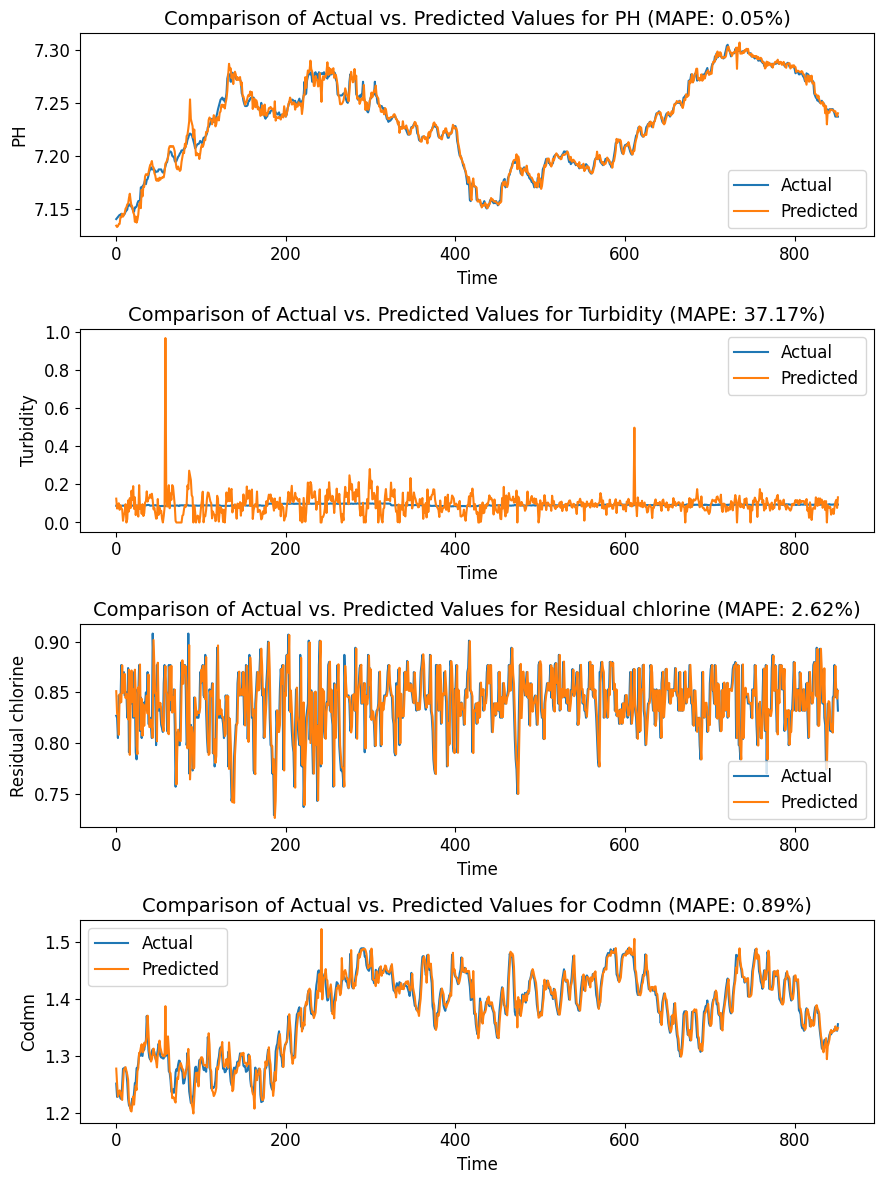

In [95]:
print("物质守恒约束的误差(在归一化之后的数据上):", f"{mape_loss * 100:.2f}%")

# 将结果逆变换到实际的单位与尺度
y = preprocessor.inverse_transform_effluent(y_test.cpu().numpy())
y_pred = preprocessor.inverse_transform_effluent(y_test_pred.cpu().numpy())
y_pred[y_pred < 0] = 0

# 将逆变换后的 NumPy 数组转换为 PyTorch 张量，供下面函数使用
y = torch.tensor(y, dtype=torch.float32).to(device)
y_pred = torch.tensor(y_pred, dtype=torch.float32).to(device)

plot_predictions(
    y=y, 
    y_pred=y_pred, 
    figsize=(9, 3), 
    variable_names=variable_names, # 用虚拟数据时不设置它
    title_fontsize=14, 
    label_fontsize=12, 
    tick_fontsize=12, 
    global_fontsize=12, 
    device=device
)

**看不投加药剂的假想情况下, 水质如何变化:**

在不投加药剂的情况下:
平均绝对误差 (MAE): 2.7037
平均绝对百分比误差 (MAPE): 2129.80%
MAE 占 y 平均值的百分比: 113.37%



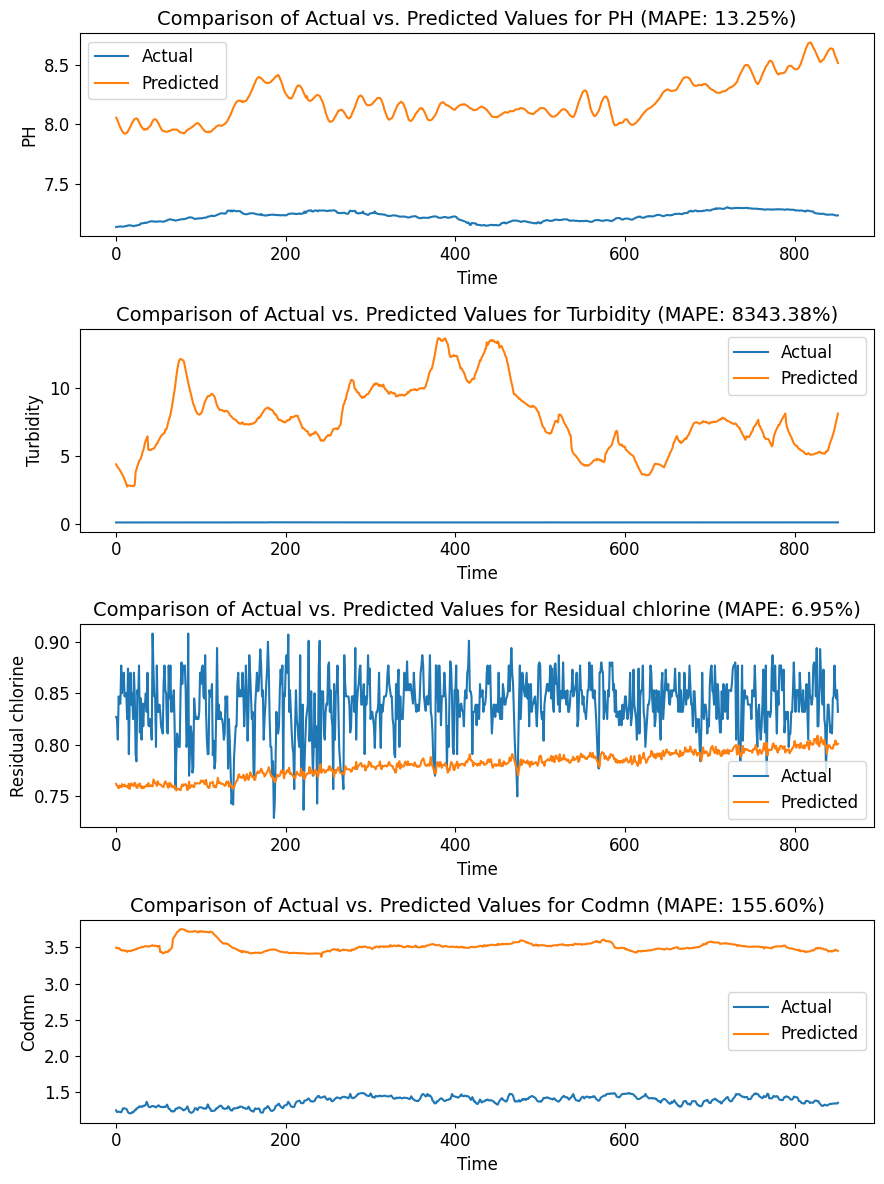

In [96]:
# 将结果逆变换到实际的单位与尺度
y = preprocessor.inverse_transform_effluent(y_test.cpu().numpy())
y_pred = preprocessor.inverse_transform_effluent(y_test_pred_0.cpu().numpy())

# 将逆变换后的 NumPy 数组转换为 PyTorch 张量，供下面函数使用
y = torch.tensor(y, dtype=torch.float32).to(device)
y_pred = torch.tensor(y_pred, dtype=torch.float32).to(device)

print("在不投加药剂的情况下:")
plot_predictions(
    y=y, 
    y_pred=y_pred, 
    figsize=(9, 3), 
    variable_names=variable_names, # 用虚拟数据时不设置它
    title_fontsize=14, 
    label_fontsize=12, 
    tick_fontsize=12, 
    global_fontsize=12, 
    device=device
)

## 训练测试不持续学习的模型

**以下各模型，在不指明变化的地方, 都是根据最优超参数而构建。**

### 定义不持续学习的模型

由于相关参数上面已经定义好, 我们可以直接定义模型:

In [23]:
# 定义一个极大的更新间隔, 就是不持续更新模型
update_interval = 9e9  # 这么多小时, 大约 1000 年
update_interval = int(update_interval)

# 定义模型
model_OneShot = TransformerModel_MassConservingCausal(
    input_dim, 
    hidden_dim, 
    output_dim, 
    SEQ_LENGTH,     
    nhead=nhead,
    nlayers=nlayers,
    embedding_dropout=embedding_dropout,
    dim_feedforward=dim_feedforward,
    transformer_dropout=transformer_dropout,
    activation=activation,
    norm_first=norm_first,
    transformer_bias=transformer_bias,
    mlp_dropout=mlp_dropout,
    mlp_dim=mlp_dim,
    residual=residual,
    causal_mask=causal_mask,    
    dosage_indices=dosage_indices,
    output_water_indices=output_water_indices,
    input_water_indices=input_water_indices
).to(device)

criterion = nn.MSELoss()

### 训练验证不持续学习的模型

In [24]:
# 阶段一：训练基础模型
if optimizer_basic_name == "Adam":
    optimizer = torch.optim.Adam(
        model_OneShot.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay_basic
    )
elif optimizer_basic_name == "AdamW":
    optimizer = torch.optim.AdamW(
        model_OneShot.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay_basic
    )
elif optimizer_basic_name == "RMSprop":
    optimizer = torch.optim.RMSprop(
        model_OneShot.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay_basic
    )
elif optimizer_basic_name == "SGD":
    optimizer = torch.optim.SGD(
        model_OneShot.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay_basic,
        momentum=0.9
    )
for epoch in tqdm(range(basic_training_epochs), desc="基础训练"):
    train_loss = train_model_MassConservingCausal(
        model_OneShot, 
        train_loader, 
        optimizer, 
        criterion, 
        device, 
        clip_value_basic
    )
    # if (epoch + 1) % 10 == 0:
    #     print(f"Epoch [{epoch+1}/{basic_training_epochs}], Train Loss: {train_loss:.4f}")

    
# 阶段二：在线持续学习，验证
all_predictions = []  # 用于存储所有预测结果的列表
all_mape_loss = []  # 用于存储所有 mape 损失的列表

for i in tqdm(range(0, len(x_val), update_interval), desc="在验证集上持续学习"):
    update_x = x_val[i:i + update_interval]
    update_y = y_val[i:i + update_interval]

    # 使用当前模型进行预测
    model_OneShot.eval()  # 设置模型为评估模式
    with torch.no_grad():
        predictions, _, _, mape_loss, _ = model_OneShot(update_x.to(device))
        all_predictions.append(predictions.cpu()) # 将预测结果移回 CPU 并添加到列表中
        all_mape_loss.append(mape_loss.cpu()) # 将 mape 损失移回 CPU 并添加到列表中

    if not len(update_x) < update_interval: # 如果数据不足 update_interval，则跳过

        update_dataset = TensorDataset(update_x, update_y)
        update_loader = DataLoader(update_dataset, batch_size=batch_size_conti, shuffle=True)

        # 微调模型 (使用较小的学习率)
        if optimizer_conti_name == "Adam":
            optimizer = torch.optim.Adam(
                model_OneShot.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "AdamW":
            optimizer = torch.optim.AdamW(
                model_OneShot.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "RMSprop":
            optimizer = torch.optim.RMSprop(
                model_OneShot.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "SGD":
            optimizer = torch.optim.SGD(
                model_OneShot.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti,
                momentum=0.9
            )   
        for epoch in range(update_epochs):
            train_loss = train_model_MassConservingCausal(
                model_OneShot, 
                update_loader, 
                optimizer, 
                criterion, 
                device, 
                clip_value_conti
            )


# 将所有预测结果拼接成一个张量
y_val_pred_OneShot = torch.cat(all_predictions, dim=0).to(device)
mape_loss = sum([loss.item() for loss in all_mape_loss]) / len(all_mape_loss)

# 确保 all_predictions 和 y_val 的大小相同
assert y_val_pred_OneShot.shape == y_val.shape, f"Predictions shape {y_val_pred_OneShot.shape} does not match y_val shape {y_val.shape}"

# 验证集评估
mape_metric = MeanAbsolutePercentageError().to(device)
mape_metric.update(y_val_pred_OneShot, y_val)
mape = mape_metric.compute()

在验证集上持续学习: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


**对比真实水质与模拟水质:**

平均绝对误差 (MAE): 0.5749
平均绝对百分比误差 (MAPE): 557.55%
MAE 占 y 平均值的百分比: 24.99%



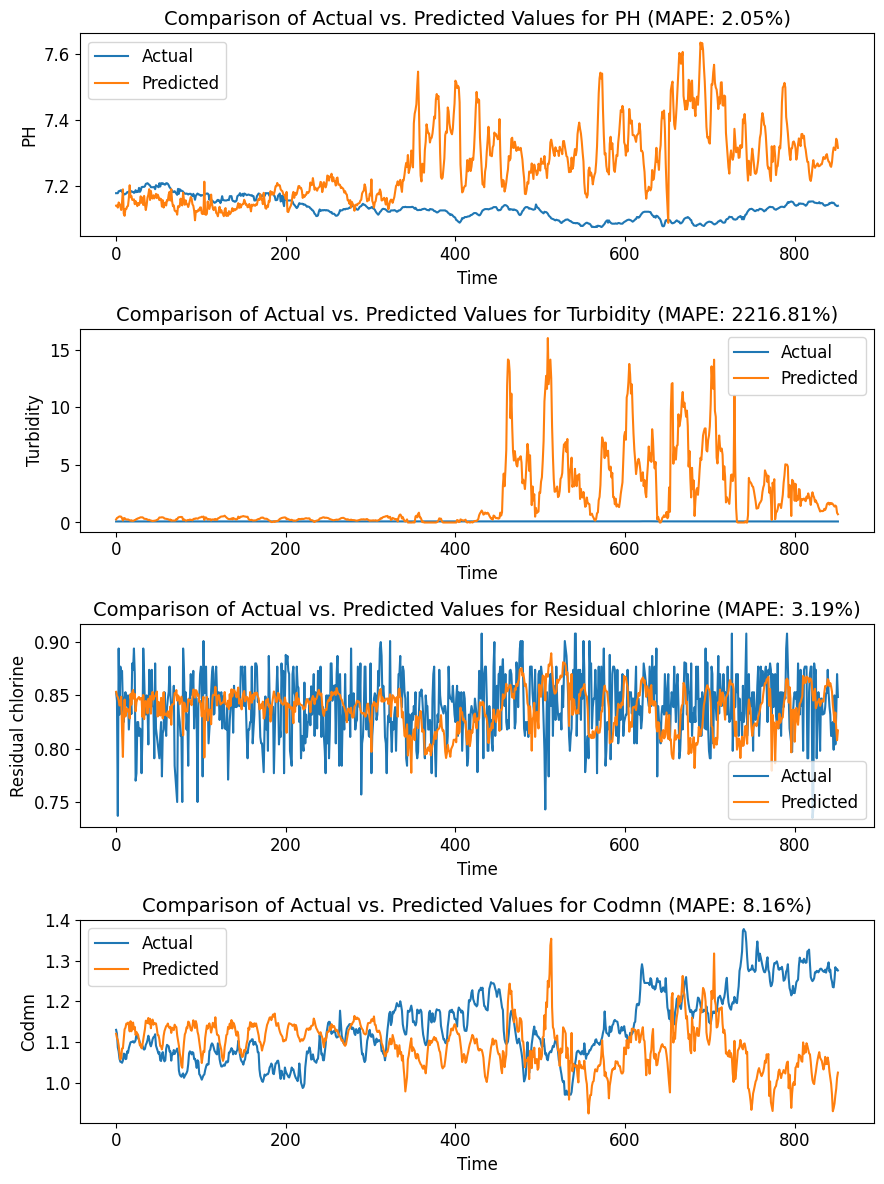

In [28]:
# 将结果逆变换到实际的单位与尺度
y = preprocessor.inverse_transform_effluent(y_val.cpu().numpy())
y_pred_OneShot = preprocessor.inverse_transform_effluent(y_val_pred_OneShot.cpu().numpy())
y_pred_OneShot[y_pred_OneShot < 0] = 0

# 将逆变换后的 NumPy 数组转换为 PyTorch 张量，供下面函数使用
y = torch.tensor(y, dtype=torch.float32).to(device)
y_pred_OneShot = torch.tensor(y_pred_OneShot, dtype=torch.float32).to(device)

plot_predictions(
    y=y, 
    y_pred=y_pred_OneShot, 
    figsize=(9, 3), 
    variable_names=variable_names, # 用虚拟数据时不设置它
    title_fontsize=14, 
    label_fontsize=12, 
    tick_fontsize=12, 
    global_fontsize=12, 
    device=device
)

### 测试不持续学习的模型

In [26]:
# 阶段三：在线持续学习，测试
all_predictions = []  # 用于存储所有预测结果的列表
all_mape_loss = []  # 用于存储所有 mape 损失的列表

for i in tqdm(range(0, len(x_test), update_interval), desc="在测试集上持续学习"):
    update_x = x_test[i:i + update_interval]
    update_y = y_test[i:i + update_interval]

    # 使用当前模型进行预测
    model_OneShot.eval()  # 设置模型为评估模式
    with torch.no_grad():
        predictions, _, _, mape_loss, _ = model_OneShot(update_x.to(device))
        all_predictions.append(predictions.cpu()) # 将预测结果移回 CPU 并添加到列表中
        all_mape_loss.append(mape_loss.cpu()) # 将 mape 损失移回 CPU 并添加到列表中

    if not len(update_x) < update_interval: # 如果数据不足 update_interval，则跳过

        update_dataset = TensorDataset(update_x, update_y)
        update_loader = DataLoader(update_dataset, batch_size=batch_size_conti, shuffle=True)

        # 微调模型 (使用较小的学习率)
        if optimizer_conti_name == "Adam":
            optimizer = torch.optim.Adam(
                model_OneShot.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "AdamW":
            optimizer = torch.optim.AdamW(
                model_OneShot.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "RMSprop":
            optimizer = torch.optim.RMSprop(
                model_OneShot.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti
            )
        elif optimizer_conti_name == "SGD":
            optimizer = torch.optim.SGD(
                model_OneShot.parameters(),
                lr=learning_rate / learning_rate_ratio,
                weight_decay=weight_decay_conti,
                momentum=0.9
            )   
        for epoch in range(update_epochs):
            train_loss = train_model_MassConservingCausal(
                model_OneShot, 
                update_loader, 
                optimizer, 
                criterion, 
                device, 
                clip_value_conti
            )


# 将所有预测结果拼接成一个张量
y_test_pred_OneShot = torch.cat(all_predictions, dim=0).to(device)
mape_loss = sum([loss.item() for loss in all_mape_loss]) / len(all_mape_loss)

# 确保 all_predictions 和 y_val 的大小相同
assert y_test_pred_OneShot.shape == y_test.shape, f"Predictions shape {y_test_pred_OneShot.shape} does not match y_test shape {y_test.shape}"

# 验证集评估
mape_metric = MeanAbsolutePercentageError().to(device)
mape_metric.update(y_test_pred, y_test)
mape = mape_metric.compute()

在测试集上持续学习: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


**对比真实水质与模拟水质:**

平均绝对误差 (MAE): 0.5197
平均绝对百分比误差 (MAPE): 401.02%
MAE 占 y 平均值的百分比: 21.79%



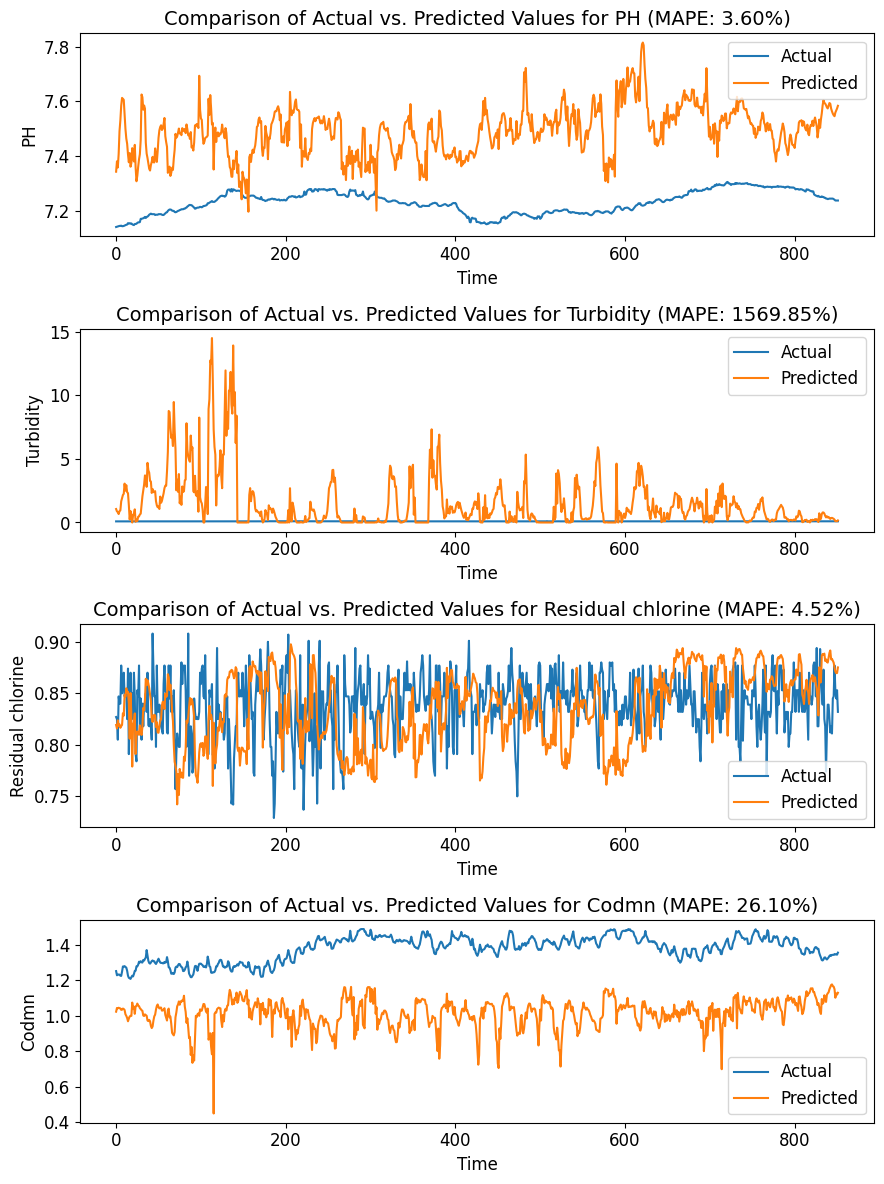

In [29]:
# 将结果逆变换到实际的单位与尺度
y = preprocessor.inverse_transform_effluent(y_test.cpu().numpy())
y_pred_OneShot = preprocessor.inverse_transform_effluent(y_test_pred_OneShot.cpu().numpy())
y_pred_OneShot[y_pred_OneShot < 0] = 0

# 将逆变换后的 NumPy 数组转换为 PyTorch 张量，供下面函数使用
y = torch.tensor(y, dtype=torch.float32).to(device)
y_pred_OneShot = torch.tensor(y_pred_OneShot, dtype=torch.float32).to(device)

plot_predictions(
    y=y, 
    y_pred=y_pred_OneShot, 
    figsize=(9, 3), 
    variable_names=variable_names, # 用虚拟数据时不设置它
    title_fontsize=14, 
    label_fontsize=12, 
    tick_fontsize=12, 
    global_fontsize=12, 
    device=device
)